In [137]:
# !pip install requests --upgrade
# !pip install bs4 --upgrade
# !pip install datetime --upgrade
# !pip install pandas --upgrade
# !pip install matplotlib --upgrade
# import nltk
# nltk.download('punkt')
# !pip install wordcloud
# !pip install vaderSentiment
# !pip install gensim
# !pip install pprint
# !pip install google-compute-engine
# !pip install pyLDAvis
!pip install sklearn

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import requests 
from bs4 import BeautifulSoup
import datetime

In [2]:
#Find top 100 movies in a specific year
def movie_from_year(year):
    import datetime
    if year< 1980 or year> int(str(datetime.datetime.now())[:4]):
        raise ValueError('Please input time during 1980 till now.')
    url = 'https://www.boxofficemojo.com/yearly/chart/?yr='+str(year)+'&p=.htm'
    response = requests.get(url)
    results = BeautifulSoup(response.content, 'lxml')
    results = results.find_all('a')        
    
    url_list=[]
    name_list = []
    for result in results:
        if result.get('href') != None:
            if 'id='in result.get('href') and '#' not in result.get_text():
                url_list.append('https://www.boxofficemojo.com'+result.get('href'))
                name_list.append(result.get_text())
    return url_list,name_list

In [3]:
#Find movie urls and names from one year to the other
def find_from_to(yearx,yeary):

    import pandas as pd
    
    list_all_url = []
    list_all_name = []
    
    for year in range(yearx,yeary+1):
        url,name = movie_from_year(year)
        list_all_url.extend(url)
        list_all_name.extend(name)
    
    return {list_all_name[i]:list_all_url[i] for i in range(len(list_all_url))}

In [4]:
# get a dictionary of {movie name: movie page url} of the yearly TOP 100 movie from 2008 to 2018
movie_url_list = find_from_to(2008,2018)

In [7]:
movie_url_list

{'The Dark Knight': 'https://www.boxofficemojo.com/movies/?id=darkknight.htm',
 'Iron Man': 'https://www.boxofficemojo.com/movies/?id=ironman.htm',
 'Indiana Jones and the Kingdom of the Crystal Skull': 'https://www.boxofficemojo.com/movies/?id=indianajones4.htm',
 'Hancock': 'https://www.boxofficemojo.com/movies/?id=hancock.htm',
 'WALL-E': 'https://www.boxofficemojo.com/movies/?id=wall-e.htm',
 'Kung Fu Panda': 'https://www.boxofficemojo.com/movies/?id=kungfupanda.htm',
 'Twilight': 'https://www.boxofficemojo.com/movies/?id=twilight08.htm',
 'Madagascar: Escape 2 Africa': 'https://www.boxofficemojo.com/movies/?id=madagascar2.htm',
 'Quantum of Solace': 'https://www.boxofficemojo.com/movies/?id=jamesbond22.htm',
 "Dr. Seuss' Horton Hears a Who!": 'https://www.boxofficemojo.com/movies/?id=hortonhearsawho.htm',
 'Sex and the City': 'https://www.boxofficemojo.com/movies/?id=sexandthecity.htm',
 'Gran Torino': 'https://www.boxofficemojo.com/movies/?id=grantorino.htm',
 'Mamma Mia!': 'http

In [5]:
#  a specifi movie's daily gross
def gross_movie(name,begin_year=1980,end_year=2018):      
    import pandas as pd
    import requests 
    from bs4 import BeautifulSoup
    try:
        movie_url = find_from_to(begin_year,end_year)[name]
        id_position = movie_url.find('id=')
        name_id = movie_url[id_position:]
        url = 'https://www.boxofficemojo.com/movies/?page=daily&view=chart&'+name_id
        response = requests.get(url)
        results = BeautifulSoup(response.content, 'lxml')
        tables = results.select('table')
        df_list = []
        for table in tables:
            df_list.append(pd.concat(pd.read_html(table.prettify())))
        movie_gross = df_list[7]
        movie_gross.columns = ['Day','Date','Rank','Gross','%daily-change','%weekly-change','Theaters','Average','Gross-to-Date','Days']
        movie_gross = movie_gross[(movie_gross['Date'] != 'Date') & (movie_gross['Date'].notnull())]
        movie_gross.set_index('Date',inplace=True)
        movie_gross[['Days']] = movie_gross[['Days']].astype(int)
        return movie_gross        
    except:
        ValueError(f'{name} is not in the TOP100 of year from to {begin_year} to {end_year}')

In [9]:
# For exampel, let's get Black Panther's daily gross
gross_Blank_Panther = gross_movie('Black Panther')

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [10]:
gross_Blank_Panther

,Day,Rank,Gross,%daily-change,%weekly-change,Theaters,Average,Gross-to-Date,Days
Date,,,,,,,,,
"Feb. 16, 2018",Fri,1,"$75,941,146",-,-,4020,"$18,891","$75,941,146",1
"Feb. 17, 2018",Sat,1,"$65,995,366",-13.1%,-,4020,"$16,417","$141,936,512",2
"Feb. 18, 2018",Sun,1,"$60,067,439",-9.0%,-,4020,"$14,942","$202,003,951",3
"Feb. 19, 2018",Mon,1,"$40,151,729",-33.2%,-,4020,"$9,988","$242,155,680",4
"Feb. 20, 2018",Tue,1,"$20,857,361",-48.1%,-,4020,"$5,188","$263,013,041",5
"Feb. 21, 2018",Wed,1,"$14,688,057",-29.6%,-,4020,"$3,654","$277,701,098",6
"Feb. 22, 2018",Thu,1,"$14,253,324",-3.0%,-,4020,"$3,546","$291,954,422",7
"Feb. 23, 2018",Fri,1,"$28,789,877",+102.0%,-62.1%,4020,"$7,162","$320,744,299",8
"Feb. 24, 2018",Sat,1,"$47,553,478",+65.2%,-27.9%,4020,"$11,829","$368,297,777",9


In [10]:
# plot a movie's gross-to-date (画一个gross_to_date的折线 和 daily gross 的bar 在一起的图)
def single_movie_gross_plot(name):
    import re
    df = gross_movie(name)
    
    # attach a new column of 'domes_gross' to the data table 
    gross = []
    pattern_1 = re.compile(r'\d+')
    for data in df['Gross-to-Date']:
        num = ''
        match = re.findall(pattern_1,data) 
        if match:
            for n in range(len(match)):
                num += match[n]
            gross.append(int(num))
        else:
            gross.append(0)
    df['GrosstoDate'] = gross  
    
    return df['GrosstoDate'].plot()

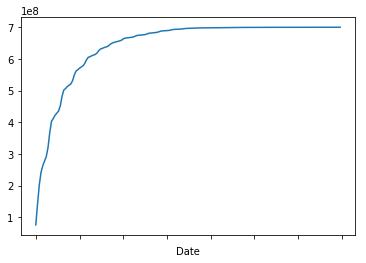

In [11]:
single_movie_gross_plot('Black Panther')

In [8]:
# plot a movie's daily-gross-percent-change
def single_movie_dailychange_plot(name):
    import re
    df = gross_movie(name)
    
    # attach a new column of 'daily_perchange' to the data table 
    change = []
    pattern_2 = re.compile(r'%$')
    for data in df['%daily-change']:
        match = re.findall(pattern_2,data) 
        if match:
            data = data.strip('+%').replace(',','')
            change.append(float(data)/100)
        else:
            change.append(0)
    df['daily_perchange'] = change   
    
    return df['daily_perchange'].plot()

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


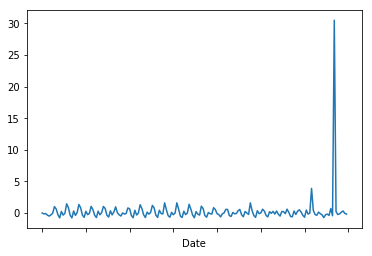

In [9]:
single_movie_dailychange_plot('Black Panther')

In [14]:
# a specifi movie's basic information
def data_movie(name,begin_year=1980,end_year=2018):      
    import pandas as pd
    import requests 
    from bs4 import BeautifulSoup
    try:
        movie_url = find_from_to(begin_year,end_year)[name]
        response = requests.get(movie_url)
        results = BeautifulSoup(response.content, 'lxml')
        tables = results.select('table')
        df_list = []
        for table in tables:
            df_list.append(pd.concat(pd.read_html(table.prettify())))
        movie_info = {}
        movie_info['Name'] = name
        
        movie_info['Genre'] = df_list[5][0].iloc[2][8:]
        movie_info['Runtime'] = df_list[5][1].iloc[2][10:]
        movie_info['Production Budget'] = df_list[5][1].iloc[3][20:]
        
        movie_info['Domestic Gross'] = df_list[9][1].iloc[0]
        try:
            movie_info['Foreign Gross'] = df_list[9][1].iloc[1]
        except:
            movie_info['Foreign Gross'] = None
        try:
            movie_info['Worldwide Gross'] = df_list[9][1].iloc[3]
        except:
            movie_info['Worldwide Gross'] = None
        
        movie_info['Release Date'] = df_list[5][1].iloc[1][15:]
    
        for n in [12,13,14,15,16]:
            if df_list[n][0].iloc[0] == 'In Release:':      
                movie_info['Inrelease Time'] = df_list[n][1].iloc[0]
                df_list[n+1].set_index(0,inplace=True)
                
                try:
                    movie_info['Actors'] = df_list[n+1][1].loc['Actors:']
                except:
                    movie_info['Actors'] = None
                
                try:
                    movie_info['Director'] = df_list[n+1][1].loc['Director:']
                except:
                    movie_info['Director'] = None   
                
                try:
                    movie_info['Producer'] = df_list[n+1][1].loc['Producer:']
                except:
                    movie_info['Producer'] = None   
                
                break
            else:
                n = n + 1
   
        movie_info['Distributor'] = df_list[5][0].iloc[1][14:]
        
        mv = pd.DataFrame(list(movie_info.items()))
        mv.columns = ['Items',name]
        mv.set_index('Items',inplace=True)
#         mv.to_csv(path_or_buf=f'./{name}Basic_info.csv')
        mv
        return mv
    except:
        ValueError(f'{name} is not in the TOP100 of year from to {begin_year} to {end_year}')

In [12]:
Black_Panther = data_movie('Black Panther',2018,2018)

In [13]:
Black_Panther

,Black Panther
Items,
Name,Black Panther
Genre,Action / Adventure
Runtime,2 hrs. 20 min.
Production Budget,N/A
Domestic Gross,"$700,059,566"
Foreign Gross,"$646,853,595"
Worldwide Gross,"$1,346,913,161"
Release Date,"February 16, 2018"
Inrelease Time,175 days / 25 weeks


In [21]:
def data_movies_table(begin_year=1980,end_year=2018,input_name=None):  
    if not input_name == None:
        name_list = input_name
    else:
        name_list = list(find_from_to(begin_year,end_year).keys())
    movie_table = data_movie(name_list[0],begin_year,end_year)
    for name in name_list[1:]:
        try:
            movie_info = data_movie(name,begin_year,end_year)
            movie_table[name]=movie_info[name]
        except:
            continue

#     mv.to_csv(path_or_buf=f'./{begin_year}-{end_year}some movies basic info.csv')
    return movie_table.T 

In [22]:
data_2018 = data_movies_table(2018,2018)

In [23]:
data_2018

Items,Name,Genre,Runtime,Production Budget,Domestic Gross,Foreign Gross,Worldwide Gross,Release Date,Inrelease Time,Actors,Director,Producer,Distributor
Black Panther,Black Panther,Action / Adventure,2 hrs. 20 min.,N/A,"$700,059,566","$646,853,595","$1,346,913,161","February 16, 2018",175 days / 25 weeks,Chadwick Boseman Lupita Nyong'o Michael B. J...,Ryan Coogler,Kevin Feige,Buena Vista
Avengers: Infinity War,Avengers: Infinity War,Action / Adventure,2 hrs. 36 min.,N/A,"$678,815,482","$1,368,094,154","$2,046,909,636","April 27, 2018",140 days / 20 weeks,"Robert Downey, Jr. Chris Hemsworth Mark Ruff...",None,Kevin Feige,Buena Vista
Incredibles 2,Incredibles 2,Animation,1 hrs. 58 min.,N/A,"$608,523,638","$632,328,436","$1,240,852,074","June 15, 2018",169 days / 24.1 weeks,Craig T. Nelson (Voice) Holly Hunter (Voice...,Brad Bird,None,Buena Vista
Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,Action / Adventure,2 hrs. 8 min.,$170 million,"$416,769,345","$888,174,715","$1,304,944,060","June 22, 2018",105 days / 15 weeks,Chris Pratt Bryce Dallas Howard Jeff Goldblu...,J.A. Bayona,None,Universal
Deadpool 2,Deadpool 2,Action,1 hrs. 59 min.,$110 million,"$318,491,426","$415,754,495","$734,245,921","May 18, 2018",154 days / 22 weeks,Ryan Reynolds Josh Brolin Morena Baccarin T...,David Leitch,None,Fox
Mission: Impossible - Fallout,Mission: Impossible - Fallout,Action,2 hrs. 27 min.,$178 million,"$220,159,104","$570,858,348","$791,017,452","July 27, 2018",84 days / 12 weeks,Tom Cruise Henry Cavill Simon Pegg Rebecca ...,Christopher McQuarrie,David Ellison (executive),Paramount
Ant-Man and the Wasp,Ant-Man and the Wasp,Action,1 hrs. 58 min.,N/A,"$216,648,740","$405,957,488","$622,606,228","July 6, 2018",119 days / 17 weeks,Paul Rudd Evangeline Lilly Michael Pena Wal...,Peyton Reed,Kevin Feige,Buena Vista
Solo: A Star Wars Story,Solo: A Star Wars Story,Action / Adventure,2 hrs. 15 min.,N/A,"$213,767,512","$179,157,295","$392,924,807","May 25, 2018",119 days / 17 weeks,Alden Ehrenreich Donald Glover Emilia Clarke...,Ron Howard,Kathleen Kennedy,Buena Vista
Venom (2018),Venom (2018),Action,1 hrs. 52 min.,$100 million,"$211,990,652","$611,228,468","$823,219,120","October 5, 2018",57 days / 8.1 weeks,Tom Hardy Michelle Williams Woody Harrelson ...,Ruben Fleischer,None,Sony / Columbia
A Star is Born (2018),A Star is Born (2018),Music Drama,2 hrs. 16 min.,$36 million,"$192,477,436","$165,100,000","$357,577,436","October 5, 2018",57 days / 8.1 weeks,Lady Gaga Bradley Cooper Sam Elliott Dave C...,Bradley Cooper,None,Warner Bros.


In [29]:
# 处理所有的票房数据
def data_movies_format_01(begin_year=1980,end_year=2018,input_name=None):  
    import re
    
    # get the table from website
    if input_name is None:
        df = data_movies_table(begin_year,end_year)
    else:
        df = data_movies_table(begin_year,end_year,input_name)
    
    #set the correct pattern of gross data
    pattern = re.compile(r'\d+')
    
    # attach a new column of 'domes_gross' to the data table 
    domes_gross = []
    for item in df['Domestic Gross']:        
        num = ''
        match = re.findall(pattern,item) 
        if match:
            for n in range(len(match)):
                num += match[n]
            domes_gross.append(int(num))
        else:
            domes_gross.append(0)
    df['domes_gross'] = domes_gross

    # attach a new column of 'forei_gross' to the data table 
    foreign_gross = []
    for item in df['Foreign Gross']:
        try:
            num = ''
            match = re.findall(pattern,item) 
            if match:
                for n in range(len(match)):
                    num += match[n]
                foreign_gross.append(int(num))
            else:
                foreign_gross.append(0)
        except:
            foreign_gross.append(0)
    df['forei_gross'] = foreign_gross    
    
    df = df[(df['domes_gross'] > 0) & (df['forei_gross'] > 0)]
    
    return df    

In [30]:
data_2018_format01 = data_movies_format_01(2018,2018)

In [31]:
data_2018_format01

Items,Name,Genre,Runtime,Production Budget,Domestic Gross,Foreign Gross,Worldwide Gross,Release Date,Inrelease Time,Actors,Director,Producer,Distributor,domes_gross,forei_gross
Black Panther,Black Panther,Action / Adventure,2 hrs. 20 min.,N/A,"$700,059,566","$646,853,595","$1,346,913,161","February 16, 2018",175 days / 25 weeks,Chadwick Boseman Lupita Nyong'o Michael B. J...,Ryan Coogler,Kevin Feige,Buena Vista,700059566,646853595
Avengers: Infinity War,Avengers: Infinity War,Action / Adventure,2 hrs. 36 min.,N/A,"$678,815,482","$1,368,094,154","$2,046,909,636","April 27, 2018",140 days / 20 weeks,"Robert Downey, Jr. Chris Hemsworth Mark Ruff...",None,Kevin Feige,Buena Vista,678815482,1368094154
Incredibles 2,Incredibles 2,Animation,1 hrs. 58 min.,N/A,"$608,523,638","$632,328,436","$1,240,852,074","June 15, 2018",169 days / 24.1 weeks,Craig T. Nelson (Voice) Holly Hunter (Voice...,Brad Bird,None,Buena Vista,608523638,632328436
Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,Action / Adventure,2 hrs. 8 min.,$170 million,"$416,769,345","$888,174,715","$1,304,944,060","June 22, 2018",105 days / 15 weeks,Chris Pratt Bryce Dallas Howard Jeff Goldblu...,J.A. Bayona,None,Universal,416769345,888174715
Deadpool 2,Deadpool 2,Action,1 hrs. 59 min.,$110 million,"$318,491,426","$415,754,495","$734,245,921","May 18, 2018",154 days / 22 weeks,Ryan Reynolds Josh Brolin Morena Baccarin T...,David Leitch,None,Fox,318491426,415754495
Mission: Impossible - Fallout,Mission: Impossible - Fallout,Action,2 hrs. 27 min.,$178 million,"$220,159,104","$570,858,348","$791,017,452","July 27, 2018",84 days / 12 weeks,Tom Cruise Henry Cavill Simon Pegg Rebecca ...,Christopher McQuarrie,David Ellison (executive),Paramount,220159104,570858348
Ant-Man and the Wasp,Ant-Man and the Wasp,Action,1 hrs. 58 min.,N/A,"$216,648,740","$405,957,488","$622,606,228","July 6, 2018",119 days / 17 weeks,Paul Rudd Evangeline Lilly Michael Pena Wal...,Peyton Reed,Kevin Feige,Buena Vista,216648740,405957488
Solo: A Star Wars Story,Solo: A Star Wars Story,Action / Adventure,2 hrs. 15 min.,N/A,"$213,767,512","$179,157,295","$392,924,807","May 25, 2018",119 days / 17 weeks,Alden Ehrenreich Donald Glover Emilia Clarke...,Ron Howard,Kathleen Kennedy,Buena Vista,213767512,179157295
Venom (2018),Venom (2018),Action,1 hrs. 52 min.,$100 million,"$211,990,652","$611,228,468","$823,219,120","October 5, 2018",57 days / 8.1 weeks,Tom Hardy Michelle Williams Woody Harrelson ...,Ruben Fleischer,None,Sony / Columbia,211990652,611228468
A Star is Born (2018),A Star is Born (2018),Music Drama,2 hrs. 16 min.,$36 million,"$192,477,436","$165,100,000","$357,577,436","October 5, 2018",57 days / 8.1 weeks,Lady Gaga Bradley Cooper Sam Elliott Dave C...,Bradley Cooper,None,Warner Bros.,192477436,165100000


In [ ]:
# 做国内票房和国外票房的占比，每一年的TOP10和TOP100，两个饼图
def domestic_foreign_dis(year1):
    import datetime
    import numpy as np
    import matplotlib.pyplot as plt
    
    if year1< 1980 or year1> int(str(datetime.datetime.now())[:4]) or year2< 1980 or year2> int(str(datetime.datetime.now())[:4]):
        raise ValueError('Please input time during 1980 till now.')
    df = data_movies_format_01(year1,year1)   
    
    top10_domes = sum(df[df['domes_gross'] > df['domes_gross'].iloc[10]]['domes_gross'])
    top10_foreign = sum(df[df['domes_gross'] > df['domes_gross'].iloc[10]]['forei_gross'])
    
       
    
    # plot pie chart of TOP10 movies' gross distribution
    labels_10 = 'TOP 10 Domestic', 'TOP 10 Foreign'
    fracs = [15, 30.55]
    # plot pie chart of TOP100 movies' gross distribution
    labels_100 = 'TOP 100 Domestic', 'TOP 100 Foreign'
    
    


In [ ]:
domestic_foreign_2018 = domestic_foreign_dis(2018)

In [ ]:
domestic_foreign_2018 

In [ ]:
# 处理所有的演员和导演数据
def data_movies_format_02(begin_year=1980,end_year=2018,input_name=None):  
    import re
    
    # get the table from website
    if input_name is None:
        df = data_movies_format_01(begin_year,end_year)
    else:
        df = data_movies_format_01(begin_year,end_year,input_name)
        
    # split directors
    df = df.drop('Actors', axis=1).join(df['Actors'].str.split('\n', expand=True).stack().reset_index(level=1, drop=True).rename('Actors'))
    
    
    # data_18ss = data_18s[data_18s['Genre'] != '/']
    
    # split actors
    
    

In [ ]:
# Find the most valuable movie actors over a specific time period
def valuable_actors(year1,year2,top=5):
    df = data_movies_format_02(year1,year2)
    
    

In [ ]:
# Find the most valuable movie directors over a specific time period
def valuable_directors(year1,year2,top=5):
    df = data_movies_table_format_02(year1,year2)
    
    

In [32]:
# define three new columns for movie showtimes, specifying date, month and the year, so as to prepare us for further analysis about showtimes.
def showtimes(df):
    import re
    pattern = r''' 
    ^                        # match beginning of string
    (?P<month>[A-Za-z]+)     # match month
    \s+                      # match space between names
    (?P<date>\d+)            # match date
    \W+
    (?P<year>\d{4})          # match year
    $                        # match end of string
'''
    flags = (re.IGNORECASE |  # Match against upper and lower case with one case
    re.VERBOSE  # Match with comments
)
    month_l = []
    date_l = []
    year_l = []
    
    for item in df['Release Date']:
        match = re.match(pattern, item, flags=flags)
        if match:
            month_l.append(match.group('month'))
            date_l.append(match.group('date'))
            year_l.append(match.group('year'))
        else:
            month_l.append(None)
            date_l.append(None)
            year_l.append(None)     
    df['month'] = month_l
    df['date'] = date_l
    df['year'] = year_l
    return df 

In [33]:
data_18 = showtimes(data_2018)
data_18

Items,Name,Genre,Runtime,Production Budget,Domestic Gross,Foreign Gross,Worldwide Gross,Release Date,Inrelease Time,Actors,Director,Producer,Distributor,month,date,year
Black Panther,Black Panther,Action / Adventure,2 hrs. 20 min.,N/A,"$700,059,566","$646,853,595","$1,346,913,161","February 16, 2018",175 days / 25 weeks,Chadwick Boseman Lupita Nyong'o Michael B. J...,Ryan Coogler,Kevin Feige,Buena Vista,February,16,2018
Avengers: Infinity War,Avengers: Infinity War,Action / Adventure,2 hrs. 36 min.,N/A,"$678,815,482","$1,368,094,154","$2,046,909,636","April 27, 2018",140 days / 20 weeks,"Robert Downey, Jr. Chris Hemsworth Mark Ruff...",None,Kevin Feige,Buena Vista,April,27,2018
Incredibles 2,Incredibles 2,Animation,1 hrs. 58 min.,N/A,"$608,523,638","$632,328,436","$1,240,852,074","June 15, 2018",169 days / 24.1 weeks,Craig T. Nelson (Voice) Holly Hunter (Voice...,Brad Bird,None,Buena Vista,June,15,2018
Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,Action / Adventure,2 hrs. 8 min.,$170 million,"$416,769,345","$888,174,715","$1,304,944,060","June 22, 2018",105 days / 15 weeks,Chris Pratt Bryce Dallas Howard Jeff Goldblu...,J.A. Bayona,None,Universal,June,22,2018
Deadpool 2,Deadpool 2,Action,1 hrs. 59 min.,$110 million,"$318,491,426","$415,754,495","$734,245,921","May 18, 2018",154 days / 22 weeks,Ryan Reynolds Josh Brolin Morena Baccarin T...,David Leitch,None,Fox,May,18,2018
Mission: Impossible - Fallout,Mission: Impossible - Fallout,Action,2 hrs. 27 min.,$178 million,"$220,159,104","$570,858,348","$791,017,452","July 27, 2018",84 days / 12 weeks,Tom Cruise Henry Cavill Simon Pegg Rebecca ...,Christopher McQuarrie,David Ellison (executive),Paramount,July,27,2018
Ant-Man and the Wasp,Ant-Man and the Wasp,Action,1 hrs. 58 min.,N/A,"$216,648,740","$405,957,488","$622,606,228","July 6, 2018",119 days / 17 weeks,Paul Rudd Evangeline Lilly Michael Pena Wal...,Peyton Reed,Kevin Feige,Buena Vista,July,6,2018
Venom (2018),Venom (2018),Action,1 hrs. 52 min.,$100 million,"$211,990,652","$611,228,468","$823,219,120","October 5, 2018",57 days / 8.1 weeks,Tom Hardy Michelle Williams Woody Harrelson ...,Ruben Fleischer,None,Sony / Columbia,October,5,2018
A Star is Born (2018),A Star is Born (2018),Music Drama,2 hrs. 16 min.,$36 million,"$192,477,436","$165,100,000","$357,577,436","October 5, 2018",57 days / 8.1 weeks,Lady Gaga Bradley Cooper Sam Elliott Dave C...,Bradley Cooper,None,Warner Bros.,October,5,2018
Dr. Seuss' The Grinch (2018),Dr. Seuss' The Grinch (2018),Animation,1 hrs. 30 min.,$75 million,"$189,674,195","$35,900,000","$225,574,195","November 9, 2018",22 days / 3.1 weeks,Benedict Cumberbatch (Voice) Rashida Jones ...,None,None,Universal,November,9,2018


In [35]:
# clean domestic gross data and change into int type
import re
gross = []
for item in data_18['Domestic Gross']:
    pattern_1 = re.compile(r'\d+')
    match_1 = re.findall(pattern_1,item) 
    num = ''
    if match_1:
        for n in range(len(match_1)):
            num += match_1[n]
        gross.append(int(num))
    else:
        gross.append(0)
data_18['domes_gross'] = gross
data_18n = data_18[data_18['domes_gross'] > 0]

In [36]:
data_18n

Items,Name,Genre,Runtime,Production Budget,Domestic Gross,Foreign Gross,Worldwide Gross,Release Date,Inrelease Time,Actors,Director,Producer,Distributor,month,date,year,domes_gross
Black Panther,Black Panther,Action / Adventure,2 hrs. 20 min.,N/A,"$700,059,566","$646,853,595","$1,346,913,161","February 16, 2018",175 days / 25 weeks,Chadwick Boseman Lupita Nyong'o Michael B. J...,Ryan Coogler,Kevin Feige,Buena Vista,February,16,2018,700059566
Avengers: Infinity War,Avengers: Infinity War,Action / Adventure,2 hrs. 36 min.,N/A,"$678,815,482","$1,368,094,154","$2,046,909,636","April 27, 2018",140 days / 20 weeks,"Robert Downey, Jr. Chris Hemsworth Mark Ruff...",None,Kevin Feige,Buena Vista,April,27,2018,678815482
Incredibles 2,Incredibles 2,Animation,1 hrs. 58 min.,N/A,"$608,523,638","$632,328,436","$1,240,852,074","June 15, 2018",169 days / 24.1 weeks,Craig T. Nelson (Voice) Holly Hunter (Voice...,Brad Bird,None,Buena Vista,June,15,2018,608523638
Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,Action / Adventure,2 hrs. 8 min.,$170 million,"$416,769,345","$888,174,715","$1,304,944,060","June 22, 2018",105 days / 15 weeks,Chris Pratt Bryce Dallas Howard Jeff Goldblu...,J.A. Bayona,None,Universal,June,22,2018,416769345
Deadpool 2,Deadpool 2,Action,1 hrs. 59 min.,$110 million,"$318,491,426","$415,754,495","$734,245,921","May 18, 2018",154 days / 22 weeks,Ryan Reynolds Josh Brolin Morena Baccarin T...,David Leitch,None,Fox,May,18,2018,318491426
Mission: Impossible - Fallout,Mission: Impossible - Fallout,Action,2 hrs. 27 min.,$178 million,"$220,159,104","$570,858,348","$791,017,452","July 27, 2018",84 days / 12 weeks,Tom Cruise Henry Cavill Simon Pegg Rebecca ...,Christopher McQuarrie,David Ellison (executive),Paramount,July,27,2018,220159104
Ant-Man and the Wasp,Ant-Man and the Wasp,Action,1 hrs. 58 min.,N/A,"$216,648,740","$405,957,488","$622,606,228","July 6, 2018",119 days / 17 weeks,Paul Rudd Evangeline Lilly Michael Pena Wal...,Peyton Reed,Kevin Feige,Buena Vista,July,6,2018,216648740
Venom (2018),Venom (2018),Action,1 hrs. 52 min.,$100 million,"$211,990,652","$611,228,468","$823,219,120","October 5, 2018",57 days / 8.1 weeks,Tom Hardy Michelle Williams Woody Harrelson ...,Ruben Fleischer,None,Sony / Columbia,October,5,2018,211990652
A Star is Born (2018),A Star is Born (2018),Music Drama,2 hrs. 16 min.,$36 million,"$192,477,436","$165,100,000","$357,577,436","October 5, 2018",57 days / 8.1 weeks,Lady Gaga Bradley Cooper Sam Elliott Dave C...,Bradley Cooper,None,Warner Bros.,October,5,2018,192477436
Dr. Seuss' The Grinch (2018),Dr. Seuss' The Grinch (2018),Animation,1 hrs. 30 min.,$75 million,"$189,674,195","$35,900,000","$225,574,195","November 9, 2018",22 days / 3.1 weeks,Benedict Cumberbatch (Voice) Rashida Jones ...,None,None,Universal,November,9,2018,189674195


In [37]:
#Start to group movies by box office. We devide the box office into three types, which are high, moderate and low, and look into genres and showtimes.
# assign movies into different groups by gross(int)
def group(df):
    box = []
    for item in data_18n['domes_gross']:
        if item >= data_18n.domes_gross.quantile(0.9):
            box.append('High')
        elif item >= data_18n.domes_gross.quantile(0.5):
            box.append('NotBad')
        else:
            box.append('Low')
    df['Box'] = box
    return df

In [38]:
data_18g = group(data_18n)
data_18g

Items,Name,Genre,Runtime,Production Budget,Domestic Gross,Foreign Gross,Worldwide Gross,Release Date,Inrelease Time,Actors,Director,Producer,Distributor,month,date,year,domes_gross,Box
Black Panther,Black Panther,Action / Adventure,2 hrs. 20 min.,N/A,"$700,059,566","$646,853,595","$1,346,913,161","February 16, 2018",175 days / 25 weeks,Chadwick Boseman Lupita Nyong'o Michael B. J...,Ryan Coogler,Kevin Feige,Buena Vista,February,16,2018,700059566,High
Avengers: Infinity War,Avengers: Infinity War,Action / Adventure,2 hrs. 36 min.,N/A,"$678,815,482","$1,368,094,154","$2,046,909,636","April 27, 2018",140 days / 20 weeks,"Robert Downey, Jr. Chris Hemsworth Mark Ruff...",None,Kevin Feige,Buena Vista,April,27,2018,678815482,High
Incredibles 2,Incredibles 2,Animation,1 hrs. 58 min.,N/A,"$608,523,638","$632,328,436","$1,240,852,074","June 15, 2018",169 days / 24.1 weeks,Craig T. Nelson (Voice) Holly Hunter (Voice...,Brad Bird,None,Buena Vista,June,15,2018,608523638,High
Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,Action / Adventure,2 hrs. 8 min.,$170 million,"$416,769,345","$888,174,715","$1,304,944,060","June 22, 2018",105 days / 15 weeks,Chris Pratt Bryce Dallas Howard Jeff Goldblu...,J.A. Bayona,None,Universal,June,22,2018,416769345,High
Deadpool 2,Deadpool 2,Action,1 hrs. 59 min.,$110 million,"$318,491,426","$415,754,495","$734,245,921","May 18, 2018",154 days / 22 weeks,Ryan Reynolds Josh Brolin Morena Baccarin T...,David Leitch,None,Fox,May,18,2018,318491426,High
Mission: Impossible - Fallout,Mission: Impossible - Fallout,Action,2 hrs. 27 min.,$178 million,"$220,159,104","$570,858,348","$791,017,452","July 27, 2018",84 days / 12 weeks,Tom Cruise Henry Cavill Simon Pegg Rebecca ...,Christopher McQuarrie,David Ellison (executive),Paramount,July,27,2018,220159104,High
Ant-Man and the Wasp,Ant-Man and the Wasp,Action,1 hrs. 58 min.,N/A,"$216,648,740","$405,957,488","$622,606,228","July 6, 2018",119 days / 17 weeks,Paul Rudd Evangeline Lilly Michael Pena Wal...,Peyton Reed,Kevin Feige,Buena Vista,July,6,2018,216648740,High
Venom (2018),Venom (2018),Action,1 hrs. 52 min.,$100 million,"$211,990,652","$611,228,468","$823,219,120","October 5, 2018",57 days / 8.1 weeks,Tom Hardy Michelle Williams Woody Harrelson ...,Ruben Fleischer,None,Sony / Columbia,October,5,2018,211990652,High
A Star is Born (2018),A Star is Born (2018),Music Drama,2 hrs. 16 min.,$36 million,"$192,477,436","$165,100,000","$357,577,436","October 5, 2018",57 days / 8.1 weeks,Lady Gaga Bradley Cooper Sam Elliott Dave C...,Bradley Cooper,None,Warner Bros.,October,5,2018,192477436,High
Dr. Seuss' The Grinch (2018),Dr. Seuss' The Grinch (2018),Animation,1 hrs. 30 min.,$75 million,"$189,674,195","$35,900,000","$225,574,195","November 9, 2018",22 days / 3.1 weeks,Benedict Cumberbatch (Voice) Rashida Jones ...,None,None,Universal,November,9,2018,189674195,High


In [39]:
####movie showtime
import re
Date = []
for item in data_18g['date']:
    pattern_1 = re.compile(r'\d+')
    match_1 = re.findall(pattern_1,item) 
    num = ''
    for n in range(len(match_1)):
        num += match_1[n]
    Date.append(int(num))
data_18g['dateint'] = Date

In [40]:
data_18g

Items,Name,Genre,Runtime,Production Budget,Domestic Gross,Foreign Gross,Worldwide Gross,Release Date,Inrelease Time,Actors,Director,Producer,Distributor,month,date,year,domes_gross,Box,dateint
Black Panther,Black Panther,Action / Adventure,2 hrs. 20 min.,N/A,"$700,059,566","$646,853,595","$1,346,913,161","February 16, 2018",175 days / 25 weeks,Chadwick Boseman Lupita Nyong'o Michael B. J...,Ryan Coogler,Kevin Feige,Buena Vista,February,16,2018,700059566,High,16
Avengers: Infinity War,Avengers: Infinity War,Action / Adventure,2 hrs. 36 min.,N/A,"$678,815,482","$1,368,094,154","$2,046,909,636","April 27, 2018",140 days / 20 weeks,"Robert Downey, Jr. Chris Hemsworth Mark Ruff...",None,Kevin Feige,Buena Vista,April,27,2018,678815482,High,27
Incredibles 2,Incredibles 2,Animation,1 hrs. 58 min.,N/A,"$608,523,638","$632,328,436","$1,240,852,074","June 15, 2018",169 days / 24.1 weeks,Craig T. Nelson (Voice) Holly Hunter (Voice...,Brad Bird,None,Buena Vista,June,15,2018,608523638,High,15
Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,Action / Adventure,2 hrs. 8 min.,$170 million,"$416,769,345","$888,174,715","$1,304,944,060","June 22, 2018",105 days / 15 weeks,Chris Pratt Bryce Dallas Howard Jeff Goldblu...,J.A. Bayona,None,Universal,June,22,2018,416769345,High,22
Deadpool 2,Deadpool 2,Action,1 hrs. 59 min.,$110 million,"$318,491,426","$415,754,495","$734,245,921","May 18, 2018",154 days / 22 weeks,Ryan Reynolds Josh Brolin Morena Baccarin T...,David Leitch,None,Fox,May,18,2018,318491426,High,18
Mission: Impossible - Fallout,Mission: Impossible - Fallout,Action,2 hrs. 27 min.,$178 million,"$220,159,104","$570,858,348","$791,017,452","July 27, 2018",84 days / 12 weeks,Tom Cruise Henry Cavill Simon Pegg Rebecca ...,Christopher McQuarrie,David Ellison (executive),Paramount,July,27,2018,220159104,High,27
Ant-Man and the Wasp,Ant-Man and the Wasp,Action,1 hrs. 58 min.,N/A,"$216,648,740","$405,957,488","$622,606,228","July 6, 2018",119 days / 17 weeks,Paul Rudd Evangeline Lilly Michael Pena Wal...,Peyton Reed,Kevin Feige,Buena Vista,July,6,2018,216648740,High,6
Venom (2018),Venom (2018),Action,1 hrs. 52 min.,$100 million,"$211,990,652","$611,228,468","$823,219,120","October 5, 2018",57 days / 8.1 weeks,Tom Hardy Michelle Williams Woody Harrelson ...,Ruben Fleischer,None,Sony / Columbia,October,5,2018,211990652,High,5
A Star is Born (2018),A Star is Born (2018),Music Drama,2 hrs. 16 min.,$36 million,"$192,477,436","$165,100,000","$357,577,436","October 5, 2018",57 days / 8.1 weeks,Lady Gaga Bradley Cooper Sam Elliott Dave C...,Bradley Cooper,None,Warner Bros.,October,5,2018,192477436,High,5
Dr. Seuss' The Grinch (2018),Dr. Seuss' The Grinch (2018),Animation,1 hrs. 30 min.,$75 million,"$189,674,195","$35,900,000","$225,574,195","November 9, 2018",22 days / 3.1 weeks,Benedict Cumberbatch (Voice) Rashida Jones ...,None,None,Universal,November,9,2018,189674195,High,9


In [41]:
# We add a new column specifying five different showtimes of movies. Traditionally, movie showtimes are divided into five parts, which are
# spring, summer, fall, winter and holiday season.
def show(df):
    showtime = []
    index = -1
    for item in df['month']:
        index += 1
        if item == 'February':
            showtime.append('winter')
        elif item == 'January':
            if df['dateint'].iloc[index] >= 3:
                showtime.append('winter')
            else:
                showtime.append('holiday')
        elif item == 'March':
            if df['dateint'].iloc[index] <= 10:
                showtime.append('winter')
            else:
                showtime.append('spring')
        elif item == 'April':
            showtime.append('spring')
        elif item == 'May':
            if df['dateint'].iloc[index] <= 6:
                showtime.append('spring')
            else:
                showtime.append('summer')
        elif item == 'June':
            showtime.append('summer')
        elif item == 'July':
            showtime.append('summer')
        elif item == 'August':
            showtime.append('summer')
        elif item == 'September':
            if df['dateint'].iloc[index] <= 5:
                showtime.append('summer')
            else:
                showtime.append('fall')
        elif item == 'October':
            showtime.append('fall')
        elif item == 'November':
            if df['dateint'].iloc[index] <= 18:
                showtime.append('fall')
            else:
                showtime.append('holiday')
        elif item == 'December':
            showtime.append('holiday')
        else:
            showtime.append(' ')
    df['showtime_def'] = showtime
    return df

In [42]:
data_show = show(data_18g)
data_show

Items,Name,Genre,Runtime,Production Budget,Domestic Gross,Foreign Gross,Worldwide Gross,Release Date,Inrelease Time,Actors,Director,Producer,Distributor,month,date,year,domes_gross,Box,dateint,showtime_def
Black Panther,Black Panther,Action / Adventure,2 hrs. 20 min.,N/A,"$700,059,566","$646,853,595","$1,346,913,161","February 16, 2018",175 days / 25 weeks,Chadwick Boseman Lupita Nyong'o Michael B. J...,Ryan Coogler,Kevin Feige,Buena Vista,February,16,2018,700059566,High,16,winter
Avengers: Infinity War,Avengers: Infinity War,Action / Adventure,2 hrs. 36 min.,N/A,"$678,815,482","$1,368,094,154","$2,046,909,636","April 27, 2018",140 days / 20 weeks,"Robert Downey, Jr. Chris Hemsworth Mark Ruff...",None,Kevin Feige,Buena Vista,April,27,2018,678815482,High,27,spring
Incredibles 2,Incredibles 2,Animation,1 hrs. 58 min.,N/A,"$608,523,638","$632,328,436","$1,240,852,074","June 15, 2018",169 days / 24.1 weeks,Craig T. Nelson (Voice) Holly Hunter (Voice...,Brad Bird,None,Buena Vista,June,15,2018,608523638,High,15,summer
Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,Action / Adventure,2 hrs. 8 min.,$170 million,"$416,769,345","$888,174,715","$1,304,944,060","June 22, 2018",105 days / 15 weeks,Chris Pratt Bryce Dallas Howard Jeff Goldblu...,J.A. Bayona,None,Universal,June,22,2018,416769345,High,22,summer
Deadpool 2,Deadpool 2,Action,1 hrs. 59 min.,$110 million,"$318,491,426","$415,754,495","$734,245,921","May 18, 2018",154 days / 22 weeks,Ryan Reynolds Josh Brolin Morena Baccarin T...,David Leitch,None,Fox,May,18,2018,318491426,High,18,summer
Mission: Impossible - Fallout,Mission: Impossible - Fallout,Action,2 hrs. 27 min.,$178 million,"$220,159,104","$570,858,348","$791,017,452","July 27, 2018",84 days / 12 weeks,Tom Cruise Henry Cavill Simon Pegg Rebecca ...,Christopher McQuarrie,David Ellison (executive),Paramount,July,27,2018,220159104,High,27,summer
Ant-Man and the Wasp,Ant-Man and the Wasp,Action,1 hrs. 58 min.,N/A,"$216,648,740","$405,957,488","$622,606,228","July 6, 2018",119 days / 17 weeks,Paul Rudd Evangeline Lilly Michael Pena Wal...,Peyton Reed,Kevin Feige,Buena Vista,July,6,2018,216648740,High,6,summer
Venom (2018),Venom (2018),Action,1 hrs. 52 min.,$100 million,"$211,990,652","$611,228,468","$823,219,120","October 5, 2018",57 days / 8.1 weeks,Tom Hardy Michelle Williams Woody Harrelson ...,Ruben Fleischer,None,Sony / Columbia,October,5,2018,211990652,High,5,fall
A Star is Born (2018),A Star is Born (2018),Music Drama,2 hrs. 16 min.,$36 million,"$192,477,436","$165,100,000","$357,577,436","October 5, 2018",57 days / 8.1 weeks,Lady Gaga Bradley Cooper Sam Elliott Dave C...,Bradley Cooper,None,Warner Bros.,October,5,2018,192477436,High,5,fall
Dr. Seuss' The Grinch (2018),Dr. Seuss' The Grinch (2018),Animation,1 hrs. 30 min.,$75 million,"$189,674,195","$35,900,000","$225,574,195","November 9, 2018",22 days / 3.1 weeks,Benedict Cumberbatch (Voice) Rashida Jones ...,None,None,Universal,November,9,2018,189674195,High,9,fall


In [43]:
# Need more analysis on movie showtimes

In [44]:
# We begin to analyze by genre
# split the genres and make it more clear
data_18s = data_18g.drop('Genre', axis=1).join(data_18g['Genre'].str.split(' ', expand=True).stack().reset_index(level=1, drop=True).rename('Genre'))
data_18ss = data_18s[data_18s['Genre'] != '/']

In [45]:
data_18ss

,Name,Runtime,Production Budget,Domestic Gross,Foreign Gross,Worldwide Gross,Release Date,Inrelease Time,Actors,Director,Producer,Distributor,month,date,year,domes_gross,Box,dateint,showtime_def,Genre
12 Strong,12 Strong,2 hrs. 9 min.,N/A,"$45,500,164","$21,631,102","$67,131,266","January 19, 2018",70 days / 10 weeks,Chris Hemsworth Michael Shannon Michael Pena,None,None,Warner Bros.,January,19,2018,45500164,Low,19,winter,War
12 Strong,12 Strong,2 hrs. 9 min.,N/A,"$45,500,164","$21,631,102","$67,131,266","January 19, 2018",70 days / 10 weeks,Chris Hemsworth Michael Shannon Michael Pena,None,None,Warner Bros.,January,19,2018,45500164,Low,19,winter,Drama
A Quiet Place,A Quiet Place,1 hrs. 35 min.,$17 million,"$188,024,361","$152,652,838","$340,677,199","April 6, 2018",119 days / 17 weeks,Emily Blunt John Krasinski,John Krasinski,None,Paramount,April,6,2018,188024361,NotBad,6,spring,Horror
A Quiet Place,A Quiet Place,1 hrs. 35 min.,$17 million,"$188,024,361","$152,652,838","$340,677,199","April 6, 2018",119 days / 17 weeks,Emily Blunt John Krasinski,John Krasinski,None,Paramount,April,6,2018,188024361,NotBad,6,spring,Thriller
A Simple Favor,A Simple Favor,1 hrs. 56 min.,N/A,"$53,548,586","$38,474,986","$92,023,572","September 14, 2018",70 days / 10 weeks,Anna Kendrick Blake Lively Henry Golding,Paul Feig,None,Lionsgate,September,14,2018,53548586,NotBad,14,fall,Thriller
A Star is Born (2018),A Star is Born (2018),2 hrs. 16 min.,$36 million,"$192,477,436","$165,100,000","$357,577,436","October 5, 2018",57 days / 8.1 weeks,Lady Gaga Bradley Cooper Sam Elliott Dave C...,Bradley Cooper,None,Warner Bros.,October,5,2018,192477436,High,5,fall,Music
A Star is Born (2018),A Star is Born (2018),2 hrs. 16 min.,$36 million,"$192,477,436","$165,100,000","$357,577,436","October 5, 2018",57 days / 8.1 weeks,Lady Gaga Bradley Cooper Sam Elliott Dave C...,Bradley Cooper,None,Warner Bros.,October,5,2018,192477436,High,5,fall,Drama
A Wrinkle in Time,A Wrinkle in Time,1 hrs. 55 min.,N/A,"$100,478,608","$32,197,256","$132,675,864","March 9, 2018",119 days / 17 weeks,Storm Reid Oprah Winfrey Reese Witherspoon ...,Ava DuVernay,None,Buena Vista,March,9,2018,100478608,NotBad,9,winter,Fantasy
Adrift,Adrift,1 hrs. 36 min.,$35 million,"$31,445,012","$25,600,000","$57,045,012","June 1, 2018",NaN,NaN,NaN,NaN,STX Entertainment,June,1,2018,31445012,Low,1,summer,Drama
Alpha,Alpha,1 hrs. 36 min.,$51 million,"$35,857,181","$44,541,096","$80,398,277","August 17, 2018",98 days / 14 weeks,Kodi Smit-McPhee Natassia Malthe,Albert Hughes,Andrew Rona,Studio 8,August,17,2018,35857181,Low,17,summer,Action


In [46]:
# groupby genre analysis
import numpy as np
import pandas as pd
data_18ss.groupby(["Box", "Genre"])['domes_gross'].size().reset_index(name='Size')

,Box,Genre,Size
0,High,Action,7
1,High,Adventure,3
2,High,Animation,2
3,High,Drama,1
4,High,Music,1
5,Low,Action,10
6,Low,Adventure,2
7,Low,Animation,3
8,Low,Comedy,8
9,Low,Crime,5


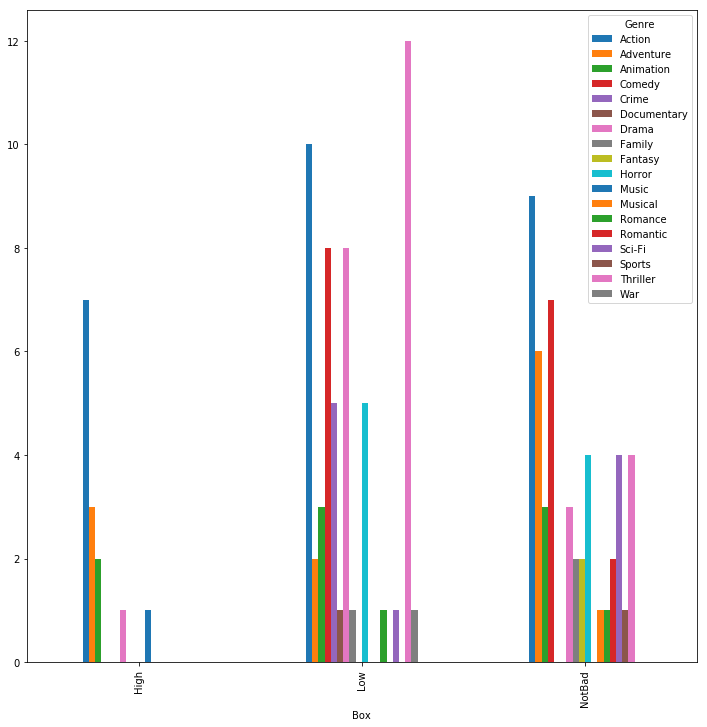

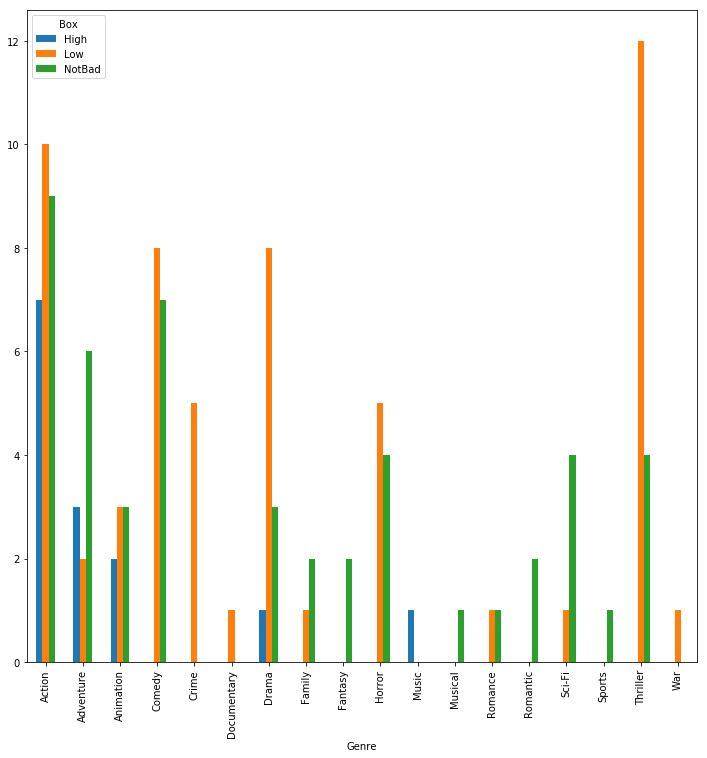

In [48]:
# groupby genre analysis: data visualization
import matplotlib.pyplot as plt
var = data_18ss.groupby(['Box', 'Genre']).size()
var.sort_values(ascending = False).unstack().plot(kind='bar',figsize=(12,12))

var = data_18ss.groupby(['Genre', 'Box']).size()
var.sort_values(ascending = False).unstack().plot(kind='bar',figsize=(12,12))
# var.unstack().plot(kind='bar', stacked=True,figsize=(12,12))
plt.show()

### We want to do some analysis about moives' features distribution and trends over time.
### Since a trend often requires a long time, which takes a long timeto see the result with the above function, we turn to another function to download the movie data, which is faster but includes fewer features.

In [138]:
# Find a movie's data with a provided url
def movie_data(url):
    from bs4 import BeautifulSoup
    import pandas as pd
    import numpy as np
    import requests
    response=requests.get(url)
    result = BeautifulSoup(response.content,'lxml')
    name = ['Name','Domestic Total Gross','Distributor','Release Time','Genre','Runtime','MPAA Rating','Production Budget','Worldwide Gross']
    data_list = [item.get_text() for item in result.find_all('b')[1:9]]
    data_list.append(result.find_all('b')[13].get_text())
    if 'Domestic Lifetime Gross:' in data_list[2]:
        data_list = [item.get_text() for item in result.find_all('b')[1:3]]
        new_list = [item.get_text() for item in result.find_all('b')[4:10]]
        data_list.extend(new_list)
        data_list.append(result.find_all('b')[14].get_text())
    if '$' not in data_list[-1]:
        data_list[-1] = 'N/A'
    a = pd.DataFrame(data_list,name)
    b = np.transpose(a)
    b.set_index('Name', inplace = True)
    return b

#Find top 100 movies' data
def movie_data_group(year):   
    import pandas as pd
    url_list,name_list = movie_from_year(year)
    list_ = []
    for url in url_list:
        try:
            a = movie_data(url)
        except:
            continue
        list_.append(a)
    try:
        return pd.concat(list_)
    except:
        return 'No data'

In [45]:
movie_2016 = movie_data_group(2016)

In [46]:
movie_2016

,Domestic Total Gross,Distributor,Release Time,Genre,Runtime,MPAA Rating,Production Budget,Worldwide Gross
Name,,,,,,,,
Rogue One:A Star Wars Story,"$532,177,324",Buena Vista,"December 16, 2016",Sci-Fi Adventure,2 hrs. 13 min.,PG-13,$200 million,"$1,056,057,273"
Finding Dory,"$486,295,561",Buena Vista,"June 17, 2016",Animation,1 hrs. 43 min.,PG,N/A,"$1,028,570,889"
Captain America:Civil War,"$408,084,349",Buena Vista,"May 6, 2016",Action / Adventure,2 hrs. 27 min.,PG-13,$250 million,"$1,153,304,495"
The Secret Life of Pets,"$368,384,330",Universal,"July 8, 2016",Animation,1 hrs. 30 min.,PG,$75 million,"$875,457,937"
The Jungle Book (2016),"$364,001,123",Buena Vista,"April 15, 2016",Adventure,1 hrs. 45 min.,PG,$175 million,"$966,550,600"
Deadpool,"$363,070,709",Fox,"February 12, 2016",Action,1 hrs. 46 min.,R,$58 million,"$783,112,979"
Zootopia,"$341,268,248",Buena Vista,"March 4, 2016",Animation,1 hrs. 48 min.,PG,N/A,"$1,023,784,195"
Batman v Superman:Dawn of Justice,"$330,360,194",Warner Bros.,"March 25, 2016",Action / Adventure,2 hrs. 31 min.,PG-13,$250 million,"$873,634,919"
Suicide Squad,"$325,100,054",Warner Bros.,"August 5, 2016",Action / Adventure,2 hrs. 10 min.,PG-13,$175 million,"$746,846,894"


In [57]:
#This function is used to draw a pie graph for the feature distributions in top 100 movies.
def pie_graph(data,feature):
    
    import pandas as pd
    import numpy as np  
    import matplotlib.pyplot as plt 
    new_data = data.groupby(feature).size().sort_values(ascending = False)
    label = list(new_data.index)
    x = list(new_data)
    abc = [(label[i],x[i]) for i in range(len(label))]
    ab = abc[:5]
    new_label = [item[0] for item in ab]
    new_x = [item[1] for item in ab]
    new_label.append('Others')
    total = [item[1] for item in abc]
    new_x.append(sum(total)-sum(new_x))
    fig = plt.figure()
    plt.axes(aspect=1)
    plt.pie(new_x,labels=new_label,autopct='%1.2f%%',shadow= True) 
    plt.title(feature.capitalize()+" Distribution")
    plt.show()

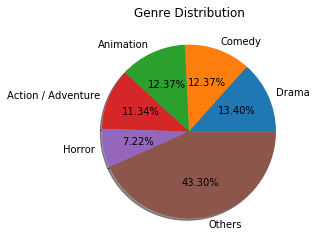

In [58]:
pie_graph(movie_2016,'Genre')

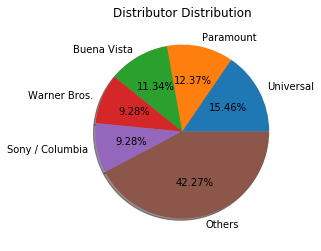

In [60]:
pie_graph(movie_2016,'Distributor')

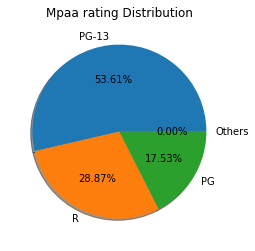

In [63]:
pie_graph(movie_2016,'MPAA Rating')

In [ ]:
#This function is used to see the trend of a specific genre in top 100 movies from a given year to a gieven year.
def movie_genre_trend(data,start_year, genres):
    import numpy as np
    import matplotlib.pyplot as plt
    year_list = list(range(len(data)))
    new_list = [year+start_year for year in year_list]
    for genre in genres:
        count = []
        for item in data:
            try:
                count.append(item.groupby('Genre').size()[genre])
            except:
                count.append(0)
        plt.plot(new_list,count,label=genre)
        plt.title('Movie Trend')
        plt.legend()

In [65]:
data_total =[]
for i in range(2010,2019):
    data_total.append(movie_data_group(i)) 

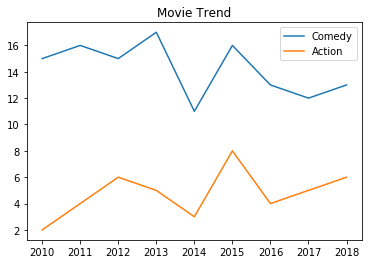

In [68]:
movie_genre_trend(data_total,2010,['Comedy','Action'] )

In [98]:
#This is a function which helps you to find the lowest budget/gross ratio movies
#It is uesful since a high box office is not a signal for a good movie unless it can spend less and earn more.
def find_hit(year,rank):
    import re
    import pandas as pd
    data = movie_data_group(year)
    list_1 = data['Production Budget'].apply(lambda x: int(re.search(r'[0-9]+',x).group())*1000000 if bool(re.search(r'[0-9]+',x))else 'N/A')
    list_2 = data['Worldwide Gross'].apply(lambda x: int(x[1:].replace(',','')) if x!= 'N/A' else 'N/A')
    list_3 = []
    for i in range(len(list_1)):
        if list_1[i]!= 'N/A' and list_2[i] !='N/A': 
            list_3.append(list_1[i]/list_2[i])
        else:
            list_3.append('N/A')
    data['Ratio'] = ['%.2f%%' % (item * 100) if type(item)!= str else 'N/A' for item in list_3]
    df = pd.DataFrame(data['Ratio'].apply(lambda x: float(x[:-1]) if x!='N/A' else 1000).sort_values(ascending =True)[:rank])
    genre_list = []
    distributor_list = []
    for name in df.index:
        genre_list.append(data.loc[name]['Genre'])
        distributor_list.append(data.loc[name]['Distributor'])
    df['Genre'] = genre_list
    df['Distributor'] = distributor_list
    df['Ratio'] = df['Ratio'].apply(lambda x:str(x)+'%')
    return df

In [99]:
# For example, let's see the top 20 low budget/gross ratio movies,with their genres and distributors
low_bg2010 = find_hit(2010,20)
low_bg2010

,Ratio,Genre,Distributor
Name,,,
The Last Exorcism,1.48%,Horror,Lionsgate
Paranormal Activity 2,1.69%,Horror,Paramount
The King's Speech,3.62%,Historical Drama,Weinstein Company
Black Swan,3.95%,Drama / Thriller,Fox Searchlight
The Twilight Saga:Eclipse,9.74%,Romance,Summit Entertainment
Easy A,10.67%,Romantic Comedy,Sony / Screen Gems
The Karate Kid,11.14%,Action Drama,Sony / Columbia
Jackass 3-D,11.65%,Comedy,Paramount
Despicable Me,12.7%,Animation,Universal


In [101]:
#This function helps users to find some news titles of one of the top 100 movie with a known year.
def news_of_movie(name, year):
    import requests
    from bs4 import BeautifulSoup
    data = find_from_to(year,year)
    url = data[name]
    response = requests.get(url)
    results = BeautifulSoup(response.content, 'lxml')
    news_list = []
    for item in results.find_all('a'):
        if 'news/?' in item.get('href'):
            news_list.append(item.get_text())
    return news_list

In [102]:
# For example, if you want to know some news about Incredibles 2.
news_of_movie('Incredibles 2', 2018)

['9/11 Summer 2018 Delivers $4.38 Billion in Domestic Grosses, Keeping Year on Record Pace',
 "9/2 'Crazy Rich Asians' Tops Labor Day Weekend, 'Fallout' is Big in China & 'Incredibles 2' Tops $600 Million",
 "8/30 It's Going to be a 'Crazy Rich' Labor Day Weekend",
 '8/8 July Box Office Grosses Were Down, but 2018 is Still on a Record Pace',
 "7/29 'Mission: Impossible - Fallout' Debuts With Franchise Best, $61.5M Opening",
 "7/22 Sequels Dominate as Denzel's 'Equalizer 2' Edges Out 'Mamma Mia!' Sequel at Top of Box Office",
 "7/19 Sequels Continue to Arrive as 'Mamma Mia 2', 'Equalizer 2' and 'Unfriended 2' Hit Theaters",
 "7/15 'Hotel Transylvania 3' Tops Weekend Box Office While 'Skyscraper' Struggles",
 "7/12 'Hotel Transylvania 3' & 'Skyscraper' Aim to Top Weekend Box Office",
 "7/8 'Ant-Man and the Wasp' Buzzes to #1 While 'Incredibles 2' Tops $500 Million",
 "7/5 'Ant-Man and the Wasp' Ready to Add to Disney's Super-Sized 2018",
 '7/3 Record June Caps off a Record Second Quarter

In [113]:
# With this function, users can see a specific year's top 5 movie market shares 
# through a pie graph.
def market_data(year):
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd
    import matplotlib.pyplot as plt 
    if year<2000 or year> int(str(datetime.datetime.now())[:4]):
        raise ValueError('Please input year no earlier than 2000 and later than this year.')

    url = 'https://www.boxofficemojo.com/studio/?view=company&view2=yearly&yr='+str(year)+'&p=.htm'
    response = requests.get(url)
    results = BeautifulSoup(response.content, 'lxml')
    list_= results.find_all('b')[7:]
    list_new = list_[:-4]
    dict_new = {}
    for i in range(len(list_new)):
        if i%2 == 0:
            dict_new[list_new[i].get_text()]=list_new[i+1].get_text()
    df = pd.Series(dict_new)
    label = list(df.index)
    x = list(df)
    x = [float(item[:-1]) for item in x]
    abc = [(label[i],x[i]) for i in range(len(label))]
    ab = abc[:5]
    new_label = [item[0] for item in ab]
    new_x = [item[1] for item in ab]
    new_label.append('Others')
    total = [item[1] for item in abc]
    new_x.append(sum(total)-sum(new_x))
    fig = plt.figure()
    plt.axes(aspect=1)
    plt.pie(new_x,labels=new_label,autopct='%1.2f%%',shadow= True) 
    plt.title(f'{year} Year Movie Market Distribution')
    plt.show()

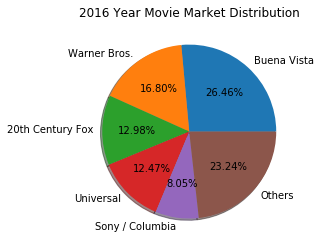

In [114]:
# For example, if you want to see the share distribution of 2016.
market_data(2016)

In [116]:
# With this function, users can find the specified distributor's released movie in a year.
def distributor_movie(name,year):
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd
    import matplotlib.pyplot as plt 
    if year<2000 or year> int(str(datetime.datetime.now())[:4]):
        raise ValueError('Please input year no earlier than 2000 and later than this year.')

    url = 'https://www.boxofficemojo.com/studio/?view=company&view2=yearly&yr='+str(year)+'&p=.htm'
    response = requests.get(url)
    results = BeautifulSoup(response.content, 'lxml')
    list_= results.find_all('b')[7:]
    list_new = list_[:-4]
    list_distributor = []
    for i in range(len(list_new)): 
        if i % 2 ==0:
            list_distributor.append(list_new[i])
    list_2 = results.find_all('a')
    list_3 = []
    for item in list_2:
        if '/studio/chart/?yr' in item.get('href'):
            list_3.append('https://www.boxofficemojo.com'+item.get('href'))
    dict_new = {}
    for i in range(len(list_distributor)):
        dict_new[list_distributor[i].get_text()] = list_3[i]

    try:
        url =dict_new[name]
    except:
        raise ValueError('Sorry, cannot find the distributor in the list of the specified year.')
    response = requests.get(url)
    results = BeautifulSoup(response.content,'lxml')
    movie_list = []
    list_open = []
    for item in results.find_all('a'):
        if 'movies/?id' in item.get('href') and '#1' not in item.get_text():
            movie_list.append(item.get_text())
        if 'schedule/?' in item.get('href'):
            list_open.append(item.get_text())

    box_list = []
    for item in results.find_all('b'):
        if '$' in item.get_text():
            box_list.append(item.get_text())

    dict_box ={}
    for i in range(len(box_list)):
        dict_box[movie_list[i]] = box_list[i]
    df = pd.DataFrame(pd.Series(dict_box),columns = ['Gross'])
    df['Open Date'] = list_open
    return df

In [117]:
#For example, if you want to see the movies released by Warner Bros. in 2018.
distributor_movie('Warner Bros.',2018)

,Gross,Open Date
A Star is Born (2018),"$191,003,172",10/5/18
Crazy Rich Asians,"$173,880,418",8/15/18
The Meg,"$143,005,856",8/10/18
Ocean's 8,"$139,377,762",6/8/18
Ready Player One,"$137,018,455",3/29/18
The Nun,"$117,450,119",9/7/18
Fantastic Beasts: The Crimes of Grindelwald,"$116,554,309",11/16/18
Rampage (2018),"$99,345,950",4/13/18
Smallfoot,"$81,935,912",9/28/18
Game Night,"$69,001,013",2/23/18


In [95]:
#Start to group movies by box office. We devide the box office into three types, which are high, moderate and low, and look into genres and showtimes.
# assign movies into different groups by gross(int)
def group(df):
    box=[]
    for item in data_18['domes_gross']:
        if item >= 400000000:
            box.append('High')
        elif item>=200000000:
            box.append('NotBad')
        else:
            box.append('Low')
    df['Box'] = box
    return df
data_18g = group(data_18)

# split the genres and make it more clear
data_s=data_18.drop('Genre', axis=1).join(data_18['Genre'].str.split('/', expand=True).stack().reset_index(level=1, drop=True).rename('Genre'))
data_s

# groupby genre analysis
import numpy as np
import pandas as pd
data_s.groupby(["Box", "Genre"])['domes_gross'].size().reset_index(name='Size')
## data_18s
grouped = data_s.groupby(["Box","Genre"])
a1=data_s.groupby(["Box","Genre"]).agg({'domes_gross':'sum'})
a2=a1.groupby(level=0).apply(lambda x:100*x/float(x.sum()))
a2

NameError: name 'data_18' is not defined

In [4]:
def get_review(name, page_length = 2, num = 20):
    import requests
    from bs4 import BeautifulSoup
    url = 'https://www.rottentomatoes.com/m/'+name+'/reviews/'
    response = requests.get(url)
    results_page = BeautifulSoup(response.content, 'lxml')
    results = results_page.find_all('div', class_ = 'the_review')
    page = 1
    reviews = list()
    next_page_results = list()

    while page < page_length:
        for item in results_page.find_all('a', class_ = 'btn btn-xs btn-primary-rt'):
            if item.find('span', class_ = "glyphicon glyphicon-chevron-right"):
                url = 'https://www.rottentomatoes.com' + item.get('href')
        response = requests.get(url)
        results_page = BeautifulSoup(response.content, 'lxml')
        next_page_results = results_page.find_all('div', class_ = 'the_review')
        results.extend(next_page_results)
        page+=1
    for result in results:
        reviews.append(result.get_text())

    return reviews[:num]

In [5]:
def get_name_review(year, num = 30, page_length = 2, length = 20):
    movies = list(find_from_to(year,year).keys())
    for i in range(len(movies)):
        movies[i] = movies[i].lower().replace(' ', '_').replace(':', '').replace(',', '_').replace('.', '_').replace("'", '').replace('!', '_').replace('?', '').replace('-', '_').replace('(', '').replace(')', '').replace('_a_new_dragon_tattoo_story','').replace('the_equalizer_2','equalizer_2').replace('dr__seuss_the_grinch_2018','the_grinch').replace('disneys_','')
        movies[i] = movies[i].lower().replace('___', '_')
        movies[i] = movies[i].lower().replace('__', '_')
    review_list = list()
    name_list = list(find_from_to(year,year).keys())[:num]
    for movie in movies[:num]:
        review = get_review(movie, page_length, length)
        if not review or len(review)<5:
            try:
                review = get_review(movie+f'_{year}', page_length, length)
            except:
                print('Do not find the movie')
        
        review_list.append(' '.join(review))
    name_review = list(zip(name_list, review_list))
    return name_review

name_review = get_name_review(2018)

In [7]:
def get_pos_neg_words():
    def get_words(url):
        import requests
        words = requests.get(url).content.decode('latin-1')
        word_list = words.split('\n')
        index = 0
        while index < len(word_list):
            word = word_list[index]
            if ';' in word or not word:
                word_list.pop(index)
            else:
                index+=1
        return word_list

    #Get lists of positive and negative words
    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    positive_words = get_words(p_url)
    negative_words = get_words(n_url)
    return positive_words,negative_words

In [8]:
def do_pos_neg_sentiment_analysis(reviews):
    positive_words,negative_words = get_pos_neg_words()
    from nltk import word_tokenize
    results = list()
    for review in reviews:
        cpos = cneg = lpos = lneg = 0
        for word in word_tokenize(review[1]):
            if word in positive_words:
                cpos+=1
            if word in negative_words:
                cneg+=1
        results.append((review[0],cpos/len(word_tokenize(review[1])),cneg/len(word_tokenize(review[1]))))
        
    import pandas as pd    
    df_simple = pd.DataFrame(results, columns = ['name', 'positive', 'negative'])
    df_simple.set_index('name', inplace = True)
    df_simple.sort_values(by = 'positive', ascending = False, inplace = True)
    
    return df_simple
df_simple = do_pos_neg_sentiment_analysis(name_review)

In [9]:
def get_nrc_data():
    nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
    count=0
    emotion_dict=dict()
    with open(nrc,'r') as fp:
        lines = list()
        for line in fp:
            if count < 46:
                count+=1
                continue
            line = line.strip().split('\t')
            if int(line[2]) == 1:
                if emotion_dict.get(line[0]):
                    emotion_dict[line[0]].append(line[1])
                else:
                    emotion_dict[line[0]] = [line[1]]
    return emotion_dict
emotion_dict = get_nrc_data()

In [10]:
def comparative_emotion_analyzer(reviews,object_name="name"):
    def emotion_analyzer(review,emotion_dict=emotion_dict):
        emotions = {x for y in emotion_dict.values() for x in y}
        emotion_count = dict()
        for emotion in emotions:
            emotion_count[emotion] = 0

        total_words = len(review.split())
        for word in review.split():
            if emotion_dict.get(word):
                for emotion in emotion_dict.get(word):
                    emotion_count[emotion] += 1/len(review.split())
        return emotion_count

    import pandas as pd
    df = pd.DataFrame(columns=[object_name,'Fear','Trust','Negative',
                           'Positive','Joy','Disgust','Anticipation',
                           'Sadness','Surprise'],)
    df.set_index(object_name,inplace=True)
      
    for review in reviews:
        result = emotion_analyzer(review[1])
        df.loc[review[0]] = [result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']]
        
    df['All_positive'] = df['Trust'] + df['Positive'] + df['Joy'] + df['Anticipation'] + df['Surprise']
    df['All_negative'] = df['Negative'] +df['Disgust'] +df['Sadness']
    df.sort_values('All_positive', ascending = False, inplace = True)
    
    return df
        
df_nrc = comparative_emotion_analyzer(name_review)

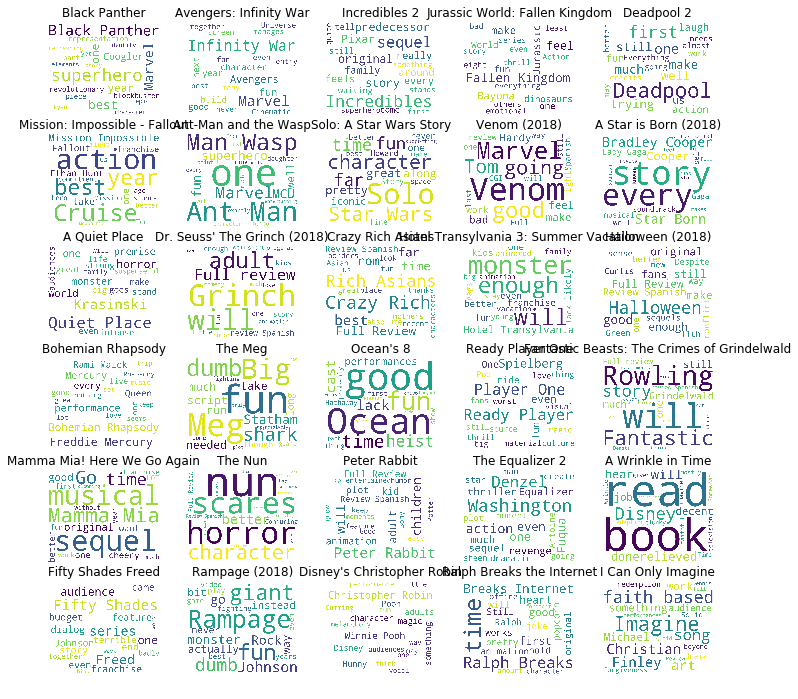

In [28]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
#Remove unwanted words
DELETE_WORDS = ['movie', 'film']
def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string

#Remove short words
MIN_LENGTH = 0
def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+word+' ',' ',1)
    return text_string


#Set up cloud
COL_NUM = 5
ROW_NUM = 6
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i in range(0,len(name_review)):
    text_string = remove_words(name_review[i][1])
    text_string = remove_short_words(text_string)
    ax = axes[i//5, i%5] 
    ax.set_title(name_review[i][0])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=1200,height=1000,max_words=20).generate(text_string)
    ax.imshow(wordcloud)
    ax.axis('off')
plt.show()

In [11]:
def vader_comparison(reviews):
    from nltk import sent_tokenize
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    import pandas as pd
    headers = ['pos','neg','neu','compound']
    analyzer = SentimentIntensityAnalyzer()
    result = list()
    
    for i in range(len(reviews)):
        name = reviews[i][0]
        sentences = sent_tokenize(reviews[i][1])
        pos=compound=neu=neg=0
        for sentence in sentences:
            vs = analyzer.polarity_scores(sentence)
            pos+=vs['pos']/(len(sentences))
            compound+=vs['compound']/(len(sentences))
            neu+=vs['neu']/(len(sentences))
            neg+=vs['neg']/(len(sentences))
        result.append([name, pos, neg, neu, compound])
        
    df_v = pd.DataFrame(result, columns = ['name','pos','neg','neu','compound'])
    df_v.set_index('name', inplace = True)
    df_v.sort_values(by = 'compound', ascending = False, inplace = True)
    
    return df_v
df_v = vader_comparison(name_review)

In [12]:
def get_recommendation(num):
    import pandas as pd
    df_v['score1'] = np.arange(30,0,-1)
    df_nrc['score2'] = np.arange(30,0,-1)
    df_simple['score3'] = np.arange(30,0,-1)

    df = pd.merge(pd.DataFrame(df_v['score1']), pd.DataFrame(df_nrc['score2']), left_index=True, right_index=True)
    result = pd.merge(df, pd.DataFrame(df_simple['score3']), left_index=True, right_index=True)
    result['total_score'] = result['score1'] + result['score3'] + result['score3']
    result.sort_values(by='total_score', ascending = False, inplace = True)
    
    return list(result.index)[:num]

In [ ]:
def get_topics(num_topics = 5, passes = 10, num_words = 8):
    from nltk import sent_tokenize
    from gensim import corpora
    from gensim.models.ldamodel import LdaModel
    from gensim.parsing.preprocessing import STOPWORDS
    import pprint
    import pyLDAvis.gensim
    review_list = list()
    for review in name_review:
        review_list.append(review[1])
    for i in range(len(review_list)):
        review = review_list[i]
        sents = sent_tokenize(review)
        for j in range(len(sents)):
            sent = sents[j]
            sent = sent.strip().replace('\n','')
            sents[j] = sent
        review_list[i] = ' '.join(sents)
        
    texts = [[word for word in review.lower().split()
        if word not in STOPWORDS and word.isalnum() and not word in ['movie','film']]
        for review in review_list]
    
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda = LdaModel(corpus,id2word=dictionary,num_topics=num_topics,passes=passes)
    lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
    pp = pprint.PrettyPrinter(indent=4)
    print(pp.pprint(lda.print_topics(num_words)))
    
    return pyLDAvis.display(lda_display)
get_topics()

In [145]:
def get_decision_tree_table(year = 2018):
    df1 = movie_data_group(year-2)
    df2 = movie_data_group(year-1)
    df3 = movie_data_group(year)
    import pandas as pd
    import numpy as np
    import re
    movies = pd.concat([df1,df2,df3])[['Distributor', 'Genre', 'MPAA Rating', 'Production Budget','Worldwide Gross']]
    movies.replace('N/A', np.nan, inplace = True)
    movies = movies.dropna()
    movies['Worldwide Gross'] = movies['Worldwide Gross'].map(lambda x: int(x[1:].replace(',','')))
    movies['Production Budget']= movies['Production Budget'].map(lambda x: float(x.replace(' million', '')[1:]))
    movies.loc[movies['MPAA Rating']=='PG','MPAA Rating'] = 1
    movies.loc[movies['MPAA Rating']=='PG-13','MPAA Rating'] = 2
    movies.loc[movies['MPAA Rating']=='R','MPAA Rating'] = 3
    pattern = re.compile(r'^([a-zA-Z-]+)[ /]*\w*$')
    movies['Genre'] = movies['Genre'].map(lambda x: re.findall(pattern, x)[0])
    [movies.loc[movies['Genre']=='Sci-Fi','Genre'], movies.loc[movies['Genre']=='Action','Genre'], movies.loc[movies['Genre']=='Animation','Genre'],
    movies.loc[movies['Genre']=='Adventure','Genre'],movies.loc[movies['Genre']=='Fantasy','Genre'],movies.loc[movies['Genre']=='Drama','Genre'],
    movies.loc[movies['Genre']=='Musical','Genre'],movies.loc[movies['Genre']=='Horror','Genre'],movies.loc[movies['Genre']=='Comedy','Genre'],
    movies.loc[movies['Genre']=='Western','Genre'],movies.loc[movies['Genre']=='Thriller','Genre'],movies.loc[movies['Genre']=='Family','Genre'],
    movies.loc[movies['Genre']=='Crime','Genre'],movies.loc[movies['Genre']=='Romance','Genre'],movies.loc[movies['Genre']=='Romantic','Genre'],
    movies.loc[movies['Genre']=='War','Genre'],movies.loc[movies['Genre']=='Period','Genre'],movies.loc[movies['Genre']=='Music','Genre'],
    movies.loc[movies['Genre']=='Sports','Genre'],movies.loc[movies['Genre']=='Historical','Genre']]= list(range(20))
    [movies.loc[movies['Distributor']=='Buena Vista','Distributor'], movies.loc[movies['Distributor']=='Universal','Distributor'], movies.loc[movies['Distributor']=='Fox','Distributor'],
    movies.loc[(movies['Distributor']=='Warner Bros. (New Line)')|(movies['Distributor']=='Warner Bros.'),'Distributor'],movies.loc[movies['Distributor']=='Paramount','Distributor'],movies.loc[(movies['Distributor']=='Lionsgate/Summit')|(movies['Distributor']=='Lionsgate'),'Distributor'],
    movies.loc[(movies['Distributor']=='Sony / Columbia')|(movies['Distributor']=='Sony / Screen Gems')|(movies['Distributor']=='Sony / AFFIRM Films'),'Distributor'],movies.loc[movies['Distributor']=='STX Entertainment','Distributor'],movies.loc[movies['Distributor']=='Focus Features','Distributor'],
    movies.loc[movies['Distributor']=='TriStar','Distributor'],movies.loc[movies['Distributor']=='Weinstein Company','Distributor'],movies.loc[movies['Distributor']=='Roadside Attractions','Distributor'],
    movies.loc[movies['Distributor']=='Open Road Films','Distributor'],movies.loc[movies['Distributor']=='A24','Distributor'],movies.loc[movies['Distributor']=='Entertainment Studios','Distributor'],
    movies.loc[movies['Distributor']=='Aviron','Distributor'],movies.loc[movies['Distributor']=='Bleecker Street','Distributor'],movies.loc[movies['Distributor']=='Fox Searchlight','Distributor'],
    movies.loc[movies['Distributor']=='MGM','Distributor'],movies.loc[movies['Distributor']=='Studio 8','Distributor']]= list(range(20))
    movies.loc[movies['Worldwide Gross']<=movies['Worldwide Gross'].describe()['75%'],'Worldwide Gross'] = 0
    # movies.loc[(movies['Worldwide Gross']>movies['Worldwide Gross'].describe()['25%']) & (movies['Worldwide Gross']<=movies['Worldwide Gross'].describe()['50%']),'Worldwide Gross'] = 2
    # movies.loc[(movies['Worldwide Gross']>movies['Worldwide Gross'].describe()['50%']) & (movies['Worldwide Gross']<=movies['Worldwide Gross'].describe()['75%']),'Worldwide Gross'] = 3
    movies.loc[movies['Worldwide Gross']>movies['Worldwide Gross'].describe()['75%'],'Worldwide Gross'] = 1

    return movies
movies = get_decision_tree_table(year = 2018)

[[100   5]
 [ 18  27]]
[[35  9]
 [ 8 13]]


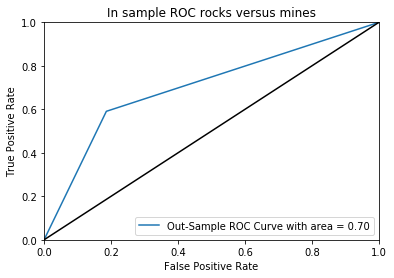

In [146]:
#Get confusion matrix and draw ROC curve
from sklearn.model_selection import train_test_split
train, test = train_test_split(movies, test_size = 0.3)
x_train = train.iloc[0:,0:4]
y_train = train[['Worldwide Gross']]
x_test = test.iloc[0:,0:4]
y_test = test[['Worldwide Gross']]

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

model = tree.DecisionTreeClassifier(max_depth = 3,criterion='entropy')
model.fit(x_train,y_train)

from sklearn.metrics import confusion_matrix
p_train=model.predict(x_train)
p_test = model.predict(x_test)
print(confusion_matrix(p_train,np.array(y_train)))
print(confusion_matrix(p_test,np.array(y_test)))

from sklearn.metrics import roc_curve,auc
import pylab as pl
%matplotlib inline
(fpr, tpr, thresholds) = roc_curve(y_test,p_test)
area = auc(fpr,tpr)
pl.clf()
pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

pl.plot([0, 1], [0, 1], 'k')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('In sample ROC rocks versus mines')
pl.legend(loc="lower right")
pl.show()